In [21]:
!pip install matplotlib


[notice] A new release of pip is available: 23.1.2 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


Import relevant librarie

In [22]:
import numpy as np
import matplotlib.pyplot as plt

In [23]:
def assign_binary_label(x1,x2):
    #function y larger than 3x + 2
    if x2 > (0.6*x1 + 0.2):
        label = 0
    else:
        label = 1
    return label

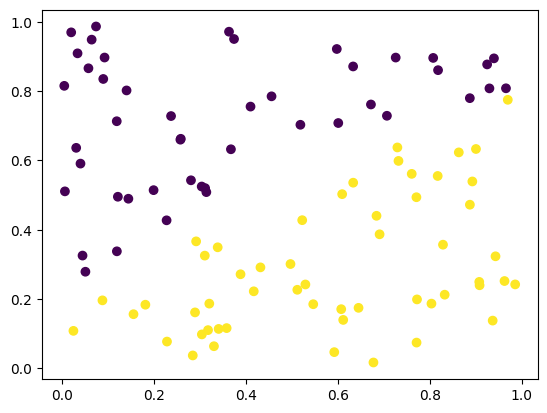

In [24]:
np.random.seed(42)  # For reproducibility

num_data_pts = 100
X = np.random.rand(num_data_pts,2)
#assign either 0 or 1
y = [assign_binary_label(x1,x2) for x1,x2 in X]

plt.scatter(X[:, 0], X[:, 1], c = y)

Initialize parameters - number of neurons in all layers and initialise weights and biases

In [25]:
input_size = 2
hidden_layer_size = 3
output_size = 1

weights = [[0.2, 0.3],[0.2, 0.3,0.1],[0.2]]
biases = [[0,0],[0,0,0],[0]]

Define activation functions to introduce non-linearity into the network
- Let´s use ReLU in the hidden layers for better performance and faster convergence
- Let´s use the sigmoid function in the output layer as it is a binary classification problem

Let´s start by implementing the sigmoid function - this is a function that maps any input value to a value between 0 and 1. It is commonly used in the output of binary classification problems. 

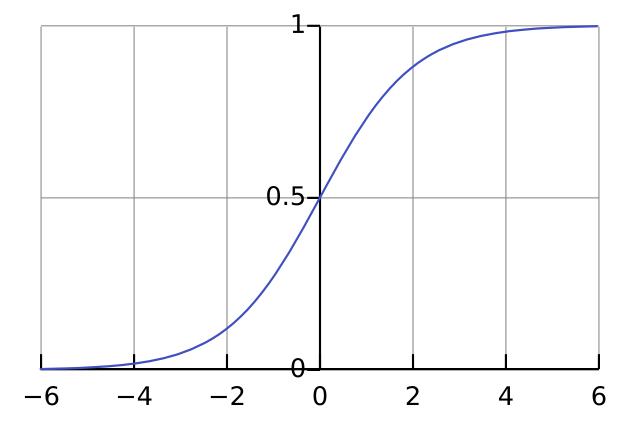

In [ ]:
import math

def sigmoid(x):
    return 1/(1+math.e^(-x))

We now implement a function to calculate the derivative of the sigmoid function - as it is used in backpropagation. We use the derivative function to help in calculating the gradient of the loss with respect to the weights. 

In [ ]:
def sigmoid_derivative(x):
    return sigmoid(x)*(1-sigmoid(x))

The ReLU (Rectified Linear Unit) function is an activation function that output the original input if it is positive, and 0 otherwise. 
The output of the ReLU ranges from 0 to infinity. It is commonly used in the hidden layers of neural networks as it helps mitigate the vanishing gradient problem and allows for faster training. 

In [ ]:
def relu(x):
    return max(x,0)

To calculate the derivative of the ReLU we need to take two cases into account - first if x is positive and second if it is negative. 

In [ ]:
def relu_derivative(x):
    if x > 0: #in this region relu(x) = x
        return 1
    else: #in this region relu(x) = 0
        return 0

Now let´s write some code to pass the data through the network from the input layer to the output layer - this is called the forward pass

In [ ]:
def forward_pass(X,W1,b1,W2,b2):
    